In [1]:
import alborexdata
import netCDF4
import glob
import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import datetime
import cmocean
from importlib import reload

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
reload(alborexdata)

<module 'alborexdata' from '/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py'>

In [3]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Configuration

In [4]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)

In [5]:
logger = alborexdata.configure_logging("./logs/alborexFigure3.log")

### Domain

In [6]:
coordinates = config["domain"]["coordinates1"]
coordinates2 = config["domain"]["coordinates2"]

In [7]:
figdir = config["figdir"]
datafilelist = sorted(config["datafiles"]["drifters"])

In [8]:
coastfile = config["datafiles"]["coast"]

## Load data 
### Coastline

In [9]:
if os.path.exists(coastfile):
    logger.info("{0} exists".format(coastfile))
    loncoast, latcoast = alborexdata.read_lonlat_coast(coastfile)
else:
    logger.warning("{0} does't exist".format(coastfile))  

2019-01-10 11:34:16,315 - alborex_logger - INFO - /home/ctroupin/Data/Alborex/Coastline/coastline_f.dat exists


### Front position

In [10]:
frontcoords = config["datafiles"]["front"]
f = alborexdata.Front()
f.get_from_file(frontcoords)
f.smooth()

## Plot

Create the projection

In [11]:
m = Basemap(projection='merc', llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
            urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
            lat_ts=0.5 * (coordinates[2] + coordinates[3]), resolution='h')

In [12]:
mzoom = Basemap(projection='merc', llcrnrlon=-1., llcrnrlat=36,
                urcrnrlon=1., urcrnrlat=37.5,
                lat_ts=36.5, resolution='h')

## Loop on the files

2019-01-10 11:34:31,761 - alborex_logger - INFO - Making figure fig08


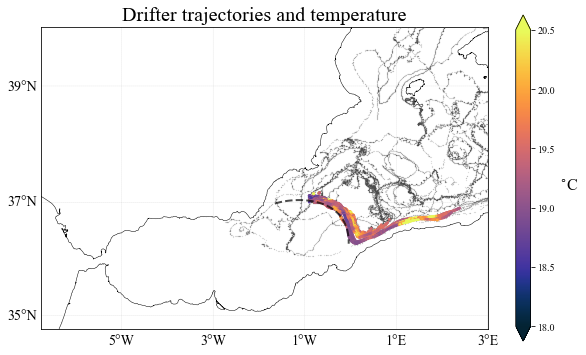

In [13]:
figname = "fig08"
figtitle = "Drifter trajectories and temperature"
logger.info("Making figure {0}".format(figname))

tmin, tmax = 18., 20.5
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
m.ax = ax

# Add the coastline
for i in range(0, len(loncoast)):
    m.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
           color='k', linewidth=.5, latlon=True)

alborexdata.add_map_grid(m, coordinates, dlon=2., dlat=2.,
                         fontname='Times New Roman', fontsize=14, 
                         linewidth=0.2, zorder=1, color=".6")

# Front position
m.plot(f.lon, f.lat, "k--", linewidth=2, latlon=True, zorder=5, alpha=.7)

for datafiles in datafilelist:
    
    # logger.debug("Working on file: {0}".format(os.path.basename(datafiles)))
    
    # Read data from file
    drifter = alborexdata.Drifter()
    drifter.get_from_netcdf(datafiles)
        
    # Apply quality flags
    drifter.apply_qc_latlon(QC=[1])

    # Add to plot
    drifter.point_plot(m, marker='o', linestyle="",
                       color=".3", ms=.1, zorder=3, alpha=.7)    
        
    if drifter.temperature is not None:
        # drifter.mask_temp(tmin, tmax)
        drifter.select_dates(finaldate=datetime.datetime(2014, 6, 1, 0, 0))
        scat = drifter.scatter_plot(m, vmin=tmin, vmax=tmax, s=3,
                                    cmap=cmocean.cm.thermal, zorder=4)
    
cb = plt.colorbar(scat, extend='both', shrink=0.6)
cb.set_label('$^{\circ}$C', rotation=0, ha='left', fontsize=16)

xtext1, ytext1 = m(-3.2, 37.)
xfig1, yfig1 = m(coordinates2[0], coordinates2[2])

plt.title(figtitle, fontsize=20)
plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot with limited data in time

## Temperature and velocity on the same plot

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/numpy/ma/core.py:2163: RuntimeWarning: invalid value encountered in less
  condition = (xf < v1) | (xf > v2)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/numpy/ma/core.py:2163: RuntimeWarning: invalid value encountered in greater
  condition = (xf < v1) | (xf > v2)
/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py:263: RuntimeWarning: divide by zero encountered in true_divide
  self.velocity = distancevec / timevec
/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py:263: RuntimeWarning: invalid value encountered in true_divide
  self.velocity = distancevec / timevec


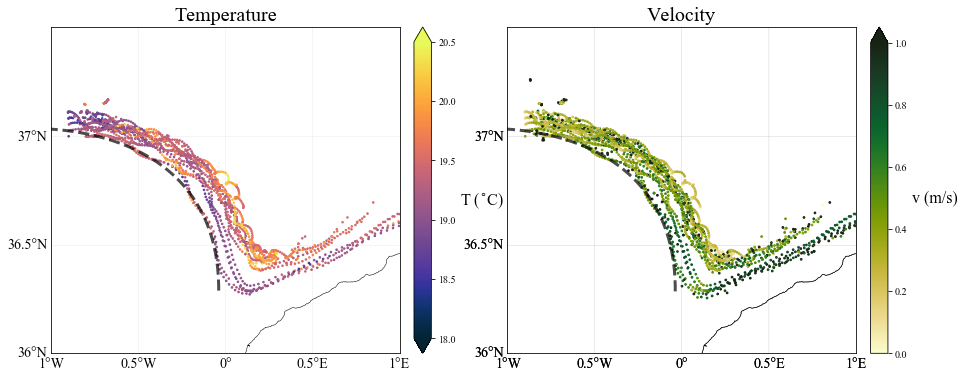

In [14]:
figname = "fig09"
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(121)
ax1.set_title("Temperature", fontsize=20)
# Add the coastline
for i in range(0, len(loncoast)):
    mzoom.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
           color='k', linewidth=.5, latlon=True, ax=ax1)

alborexdata.add_map_grid(mzoom, coordinates, dlon=.5, dlat=.5,
                         fontname='Times New Roman', fontsize=14, 
                         linewidth=0.2, zorder=1, color=".6", ax=ax1)

mzoom.plot(f.lon, f.lat, "--", linewidth=3, color="k", latlon=True, zorder=5, alpha=.7, ax=ax1)

ax2 = plt.subplot(122)
ax2.set_title("Velocity", fontsize=20)

# Add the coastline
for i in range(0, len(loncoast)):
    mzoom.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
           color='k', linewidth=.5, latlon=True, ax=ax2)

alborexdata.add_map_grid(mzoom, coordinates, dlon=.5, dlat=.5,
                         fontname='Times New Roman', fontsize=14, 
                         linewidth=0.2, zorder=1, color=".6", ax=ax2)

mzoom.plot(f.lon, f.lat, "--", linewidth=3, color="k", latlon=True, zorder=5, alpha=.7, ax=ax2)

# Add the coastline
for i in range(0, len(loncoast)):
    mzoom.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
           color='k', linewidth=.5, latlon=True)

alborexdata.add_map_grid(mzoom, coordinates, dlon=.5, dlat=.5,
                         fontname='Times New Roman', fontsize=14, 
                         linewidth=0.2, zorder=1, color=".6", ax=ax2)

for datafiles in datafilelist:
    
    # Read data from file
    drifter = alborexdata.Drifter()
    drifter.get_from_netcdf(datafiles)
    
    # Select mission period
    drifter.select_dates(finaldate=datetime.datetime(2014, 6, 1, 0, 0))

    # Compute the velocity
    drifter.compute_velocity(velmax=5.)
           
    if drifter.temperature is not None:
        drifter.mask_temp(tmin, tmax)
        scat1 = drifter.scatter_plot(mzoom, vmin=tmin, vmax=tmax, 
                                    s=2.5, cmap=cmocean.cm.thermal, zorder=4, ax=ax1)
    
    scat2 = mzoom.scatter(drifter.lon[:-1], drifter.lat[:-1], s=3, c=drifter.velocity, 
            vmin=0., vmax=1., cmap=cmocean.cm.speed, latlon=True, ax=ax2)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.2)
cb1 = plt.colorbar(scat1, cax=cax1, orientation='vertical', extend="both")
cb1.set_label("T ($^{\circ}$C)", rotation=0, ha="left", fontsize=16)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.2)
cb2 = plt.colorbar(scat2, cax=cax2, extend="max")
cb2.set_label("v (m/s)", rotation=0, ha="left", fontsize=16)

plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight',)

plt.show()
plt.close()